In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import Activation
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

Using TensorFlow backend.


In [2]:
np.random.seed(7)

In [3]:
# whether to use LSTM or MLP
use_LSTM = True

# number of features used in the regression (for MLP)
mlp_num_features = 10
#

# predict several timesteps at once
lstm_predict_sequences = False
lstm_num_predictions = 10

# lstm_num_timesteps
lstm_num_timesteps = 10
# lstm_num_features
lstm_num_features = 1
# stateful?
lstm_stateful = False
# use two lstm layers?
lstm_stack_layers = False

# window_size
window_size = lstm_num_timesteps if use_LSTM else mlp_num_features

batch_size = 1
num_epochs = 1000
# dimensionality of the output space
num_neurons = 4

# scale the dataset to values between scale_min and scale_max
scale = True
scale_min = -1
scale_max = 1
#scaler = MinMaxScaler(feature_range=(scale_min, scale_max))
scaler = StandardScaler()

# number of consecutive (dependent) predictions
prediction_window = 5 


In [4]:
testname = 'predict'
properties = 'lstm_' + str(use_LSTM) + '_stateful_' + str(lstm_stateful) + '_window_' + str(window_size) + '_predict_sequences_' + str(lstm_predict_sequences) + '_epochs_' + str(num_epochs) + '_2layers_' + str(lstm_stack_layers) + '_scale_' + str(scale)
model_name = testname + '_' + properties + '.h5'
fig_name = testname + '_' + properties + '.png'
fig_name_multiple = testname + '_' + properties + '_multiplepreds_' + str(prediction_window) + '.png'


model_exists = False

In [5]:
filename = '108_7_3.train.csv'
df_train = pd.read_csv(filename, usecols=[1])
ts_train = df_train.values.astype('float64')
df_test = pd.read_csv(filename, usecols=[1])
ts_test = df_test.values.astype('float64')
ts_all = np.append(ts_train, ts_test).reshape(-1,1)
len_overall = len(ts_all)

In [6]:
len_overall

1798

In [7]:
ts_train.shape, ts_test.shape

((899, 1), (899, 1))

In [8]:
ts_train[:10]

array([[ 4164.],
       [ 3540.],
       [ 3560.],
       [ 3094.],
       [ 3658.],
       [ 3049.],
       [ 3526.],
       [ 3290.],
       [ 4447.],
       [ 2305.]])

In [9]:
ts_test[:10]

array([[ 4164.],
       [ 3540.],
       [ 3560.],
       [ 3094.],
       [ 3658.],
       [ 3049.],
       [ 3526.],
       [ 3290.],
       [ 4447.],
       [ 2305.]])

In [10]:
if scale:
    ts_train = scaler.fit_transform(ts_train)
    ts_test = scaler.transform(ts_test)

In [11]:
ts_train[:10]

array([[ 3.31349714],
       [ 2.44480749],
       [ 2.4726501 ],
       [ 1.82391712],
       [ 2.60907893],
       [ 1.76127123],
       [ 2.42531765],
       [ 2.09677477],
       [ 3.70747018],
       [ 0.72552587]])

In [12]:
ts_test[:10]

array([[ 3.31349714],
       [ 2.44480749],
       [ 2.4726501 ],
       [ 1.82391712],
       [ 2.60907893],
       [ 1.76127123],
       [ 2.42531765],
       [ 2.09677477],
       [ 3.70747018],
       [ 0.72552587]])

In [13]:
# split into train and test sets
#train_size = int(len(ts) * 0.67)
#test_size = len(ts) - train_size
#ts_train, ts_test = ts[0:train_size,:], ts[train_size:len(ts),:]
#print(len(ts_train), len(ts_test))


In [14]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, window_size):
    dataX, dataY = [], []
    for i in range(len(dataset) - window_size):
        a = dataset[i:(i + window_size), 0]
        dataX.append(a)
        dataY.append(dataset[i + window_size, 0])
    return np.array(dataX), np.array(dataY)

In [15]:
def create_dataset_multiple_y(dataset, window_size):
    dataX, dataY = [], []
    for i in range(len(dataset) - 2 * window_size):
        a = dataset[i:(i + window_size), 0]
        #print(a)
        dataX.append(a)
        b = dataset[(i + window_size):(i + 2* window_size), 0]
        #print(b)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [16]:
if use_LSTM:
    if lstm_predict_sequences:
        X_train, y_train = create_dataset_multiple_y(ts_train, lstm_num_timesteps)
        X_test, y_test = create_dataset_multiple_y(ts_test, lstm_num_timesteps)
    else:    
        X_train, y_train = create_dataset(ts_train, lstm_num_timesteps)
        X_test, y_test = create_dataset(ts_test, lstm_num_timesteps)
else:
    X_train, y_train = create_dataset(ts_train, mlp_num_features)
    X_test, y_test = create_dataset(ts_test, mlp_num_features)
    
# the train and test matrices end up shorter than the respective timeseries by window_size + 1!
X_train.shape, y_train.shape, X_test.shape,  y_test.shape

((889, 10), (889,), (889, 10), (889,))

In [17]:
X_train[:5,:]

array([[ 3.31349714,  2.44480749,  2.4726501 ,  1.82391712,  2.60907893,
         1.76127123,  2.42531765,  2.09677477,  3.70747018,  0.72552587],
       [ 2.44480749,  2.4726501 ,  1.82391712,  2.60907893,  1.76127123,
         2.42531765,  2.09677477,  3.70747018,  0.72552587,  1.21555594],
       [ 2.4726501 ,  1.82391712,  2.60907893,  1.76127123,  2.42531765,
         2.09677477,  3.70747018,  0.72552587,  1.21555594,  1.39235655],
       [ 1.82391712,  2.60907893,  1.76127123,  2.42531765,  2.09677477,
         3.70747018,  0.72552587,  1.21555594,  1.39235655,  1.78772172],
       [ 2.60907893,  1.76127123,  2.42531765,  2.09677477,  3.70747018,
         0.72552587,  1.21555594,  1.39235655,  1.78772172,  3.13530439]])

In [18]:
y_train[:5]

array([ 1.21555594,  1.39235655,  1.78772172,  3.13530439,  1.59978405])

In [19]:
X_test[:5,:]

array([[ 3.31349714,  2.44480749,  2.4726501 ,  1.82391712,  2.60907893,
         1.76127123,  2.42531765,  2.09677477,  3.70747018,  0.72552587],
       [ 2.44480749,  2.4726501 ,  1.82391712,  2.60907893,  1.76127123,
         2.42531765,  2.09677477,  3.70747018,  0.72552587,  1.21555594],
       [ 2.4726501 ,  1.82391712,  2.60907893,  1.76127123,  2.42531765,
         2.09677477,  3.70747018,  0.72552587,  1.21555594,  1.39235655],
       [ 1.82391712,  2.60907893,  1.76127123,  2.42531765,  2.09677477,
         3.70747018,  0.72552587,  1.21555594,  1.39235655,  1.78772172],
       [ 2.60907893,  1.76127123,  2.42531765,  2.09677477,  3.70747018,
         0.72552587,  1.21555594,  1.39235655,  1.78772172,  3.13530439]])

In [20]:
y_test[:5]

array([ 1.21555594,  1.39235655,  1.78772172,  3.13530439,  1.59978405])

In [21]:
if use_LSTM:
    # reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], lstm_num_timesteps, lstm_num_features))
    X_test = np.reshape(X_test, (X_test.shape[0], lstm_num_timesteps, lstm_num_features))
    
    if lstm_predict_sequences:
        y_train = np.reshape(y_train, (y_train.shape[0], lstm_num_predictions, lstm_num_features))
        y_test = np.reshape(y_test, (y_test.shape[0], lstm_num_predictions, lstm_num_features))

In [22]:
if not model_exists:
    
    model = Sequential()

    # LSTM input shape
    # (samples, time steps, features)
    # LSTM output shape
    # if return_sequences: 3D tensor with shape (batch_size, timesteps, units).
    # else, 2D tensor with shape (batch_size, units).

    if use_LSTM:

        print('LSTM')
        # the last state for each sample at index i in a batch will be used as initial state
        # for the sample of index i in the following batch
        if lstm_stateful:
            print('stateful')
            #
            if lstm_stack_layers:
                print('stack_layers')
                model.add(LSTM(num_neurons,
                           batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]),
                           stateful = True,
                           return_sequences = True))
                print(model.output_shape)
                model.add(LSTM(num_neurons,
                           stateful = True))
                print(model.output_shape)
                model.add(Dense(1))
                print(model.output_shape)
                model.compile(loss='mean_squared_error', optimizer='adam')

            # 
            elif lstm_predict_sequences:
                print('predict_sequences')
                model.add(LSTM(num_neurons,
                           batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]),
                           stateful = True,
                           return_sequences = True))
                print(model.output_shape)
                model.add(TimeDistributed(Dense(1)))
                print(model.output_shape)
                model.add(Activation("linear"))  
                model.compile(loss='mean_squared_error', optimizer='adam')

            #    
            else:
                print('predict single')
                model.add(LSTM(num_neurons,
                           batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]),
                           stateful = True))
                print(model.output_shape)
                model.add(Dense(1))
                print(model.output_shape)
                model.compile(loss='mean_squared_error', optimizer='adam')



        # stateful == False    
        else: 
            print('stateless')

            if lstm_stack_layers:
                print('stack layers')
                # input_dim: dimensionality of the input (alternatively, input_shape)
                # required when using this layer as the first layer in a model
                model.add(LSTM(num_neurons, input_dim = lstm_num_features, return_sequences = True))
                print(model.output_shape)
                model.add(LSTM(num_neurons))
                print(model.output_shape)
                model.add(Dense(1))
                print(model.output_shape)
                model.compile(loss='mean_squared_error', optimizer='adam')
            # 
            # 
            elif lstm_predict_sequences:
                print('predict_sequences')
                model.add(LSTM(num_neurons,
                          #  input_dim = lstm_num_features,
                           batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), 
                           return_sequences = True))
                print(model.output_shape) 
                model.add(TimeDistributed(Dense(1)))
                print(model.output_shape) 
                model.compile(loss='mean_squared_error', optimizer='adam')

            else:
                print('predict single')
                model.add(LSTM(num_neurons, 
                               input_shape=(X_train.shape[1], X_train.shape[2])
                               #input_dim = lstm_num_features
                              )
                              )
                print(model.output_shape) 
                model.add(Dense(1))
                print(model.output_shape) 
                model.compile(loss='mean_squared_error', optimizer='adam')



    # feedforward
    else:
        print('MLP')

        model.add(Dense(num_neurons, input_dim = mlp_num_features, activation='relu'))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')

else:
    print('loading from file: ' + model_name)
    model = load_model(model_name)

LSTM
stateless
predict single
(None, 4)
(None, 1)


In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101.0
Trainable params: 101
Non-trainable params: 0.0
_________________________________________________________________


In [24]:
if not model_exists:
    if use_LSTM & lstm_stateful:

        for i in range(num_epochs):
                print('epoch: ' + str(i))
                # shuffle must be False!
                model.fit(X_train, y_train, epochs = 1, batch_size = batch_size, shuffle = False)
                model.reset_states()

    else: 
        model.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_size)


Epoch 1/1000
889/889 [==============================] - 6s - loss: 0.4887     
Epoch 2/1000
889/889 [==============================] - 6s - loss: 0.3469     
Epoch 3/1000
889/889 [==============================] - 6s - loss: 0.3226     
Epoch 4/1000
889/889 [==============================] - 6s - loss: 0.3172     
Epoch 5/1000
889/889 [==============================] - 6s - loss: 0.3128     
Epoch 6/1000
889/889 [==============================] - 6s - loss: 0.3100     
Epoch 7/1000
889/889 [==============================] - 6s - loss: 0.3066     
Epoch 8/1000
889/889 [==============================] - 6s - loss: 0.3068     
Epoch 9/1000
889/889 [==============================] - 6s - loss: 0.3048     
Epoch 10/1000
889/889 [==============================] - 6s - loss: 0.3040     
Epoch 11/1000
889/889 [==============================] - 6s - loss: 0.3030     
Epoch 12/1000
889/889 [==============================] - 6s - loss: 0.3020     
Epoch 13/1000
889/889 [==========================

889/889 [==============================] - 5s - loss: 0.2776     
Epoch 104/1000
889/889 [==============================] - 5s - loss: 0.2797     
Epoch 105/1000
889/889 [==============================] - 6s - loss: 0.2793     
Epoch 106/1000
889/889 [==============================] - 5s - loss: 0.2770     
Epoch 107/1000
889/889 [==============================] - 5s - loss: 0.2782     
Epoch 108/1000
889/889 [==============================] - 5s - loss: 0.2791     
Epoch 109/1000
889/889 [==============================] - 5s - loss: 0.2745     
Epoch 110/1000
889/889 [==============================] - 5s - loss: 0.2794     
Epoch 111/1000
889/889 [==============================] - 5s - loss: 0.2764     
Epoch 112/1000
889/889 [==============================] - 5s - loss: 0.2783     
Epoch 113/1000
889/889 [==============================] - 5s - loss: 0.2779     
Epoch 114/1000
889/889 [==============================] - 5s - loss: 0.2763     
Epoch 115/1000
889/889 [===================

889/889 [==============================] - 5s - loss: 0.2721     
Epoch 205/1000
889/889 [==============================] - 5s - loss: 0.2693     
Epoch 206/1000
889/889 [==============================] - 5s - loss: 0.2712     
Epoch 207/1000
889/889 [==============================] - 5s - loss: 0.2723     
Epoch 208/1000
889/889 [==============================] - 5s - loss: 0.2710     
Epoch 209/1000
889/889 [==============================] - 5s - loss: 0.2716     
Epoch 210/1000
889/889 [==============================] - 5s - loss: 0.2710     
Epoch 211/1000
889/889 [==============================] - 5s - loss: 0.2682     
Epoch 212/1000
889/889 [==============================] - 5s - loss: 0.2711     
Epoch 213/1000
889/889 [==============================] - 5s - loss: 0.2690     
Epoch 214/1000
889/889 [==============================] - 5s - loss: 0.2687     
Epoch 215/1000
889/889 [==============================] - 5s - loss: 0.2704     
Epoch 216/1000
889/889 [===================

889/889 [==============================] - 6s - loss: 0.2688     
Epoch 306/1000
889/889 [==============================] - 5s - loss: 0.2630     
Epoch 307/1000
889/889 [==============================] - 5s - loss: 0.2643     
Epoch 308/1000
889/889 [==============================] - 5s - loss: 0.2688     
Epoch 309/1000
889/889 [==============================] - 5s - loss: 0.2662     
Epoch 310/1000
889/889 [==============================] - 5s - loss: 0.2657     
Epoch 311/1000
889/889 [==============================] - 5s - loss: 0.2673     
Epoch 312/1000
889/889 [==============================] - 5s - loss: 0.2674     
Epoch 313/1000
889/889 [==============================] - 5s - loss: 0.2621     
Epoch 314/1000
889/889 [==============================] - 6s - loss: 0.2686     
Epoch 315/1000
889/889 [==============================] - 5s - loss: 0.2657     
Epoch 316/1000
889/889 [==============================] - 5s - loss: 0.2664     
Epoch 317/1000
889/889 [===================

889/889 [==============================] - 6s - loss: 0.2578     
Epoch 407/1000
889/889 [==============================] - 5s - loss: 0.2583     
Epoch 408/1000
889/889 [==============================] - 5s - loss: 0.2563     
Epoch 409/1000
889/889 [==============================] - 5s - loss: 0.2576     
Epoch 410/1000
889/889 [==============================] - 5s - loss: 0.2576     
Epoch 411/1000
889/889 [==============================] - 5s - loss: 0.2570     
Epoch 412/1000
889/889 [==============================] - 5s - loss: 0.2539     
Epoch 413/1000
889/889 [==============================] - 5s - loss: 0.2579     
Epoch 414/1000
889/889 [==============================] - 5s - loss: 0.2581     
Epoch 415/1000
889/889 [==============================] - 5s - loss: 0.2601     
Epoch 416/1000
889/889 [==============================] - 5s - loss: 0.2548     
Epoch 417/1000
889/889 [==============================] - 5s - loss: 0.2557     
Epoch 418/1000
889/889 [===================

889/889 [==============================] - 5s - loss: 0.2508     
Epoch 508/1000
889/889 [==============================] - 5s - loss: 0.2493     
Epoch 509/1000
889/889 [==============================] - 5s - loss: 0.2493     
Epoch 510/1000
889/889 [==============================] - 5s - loss: 0.2500     
Epoch 511/1000
889/889 [==============================] - 5s - loss: 0.2479     
Epoch 512/1000
889/889 [==============================] - 5s - loss: 0.2475     
Epoch 513/1000
889/889 [==============================] - 5s - loss: 0.2562     
Epoch 514/1000
889/889 [==============================] - 5s - loss: 0.2502     
Epoch 515/1000
889/889 [==============================] - 5s - loss: 0.2512     
Epoch 516/1000
889/889 [==============================] - 5s - loss: 0.2505     
Epoch 517/1000
889/889 [==============================] - 5s - loss: 0.2499     
Epoch 518/1000
889/889 [==============================] - 5s - loss: 0.2499     
Epoch 519/1000
889/889 [===================

889/889 [==============================] - 5s - loss: 0.2496     
Epoch 609/1000
889/889 [==============================] - 5s - loss: 0.2458     
Epoch 610/1000
889/889 [==============================] - 5s - loss: 0.2459     
Epoch 611/1000
889/889 [==============================] - 5s - loss: 0.2440     
Epoch 612/1000
889/889 [==============================] - 5s - loss: 0.2428     
Epoch 613/1000
889/889 [==============================] - 5s - loss: 0.2436     
Epoch 614/1000
889/889 [==============================] - 5s - loss: 0.2452     
Epoch 615/1000
889/889 [==============================] - 5s - loss: 0.2451     
Epoch 616/1000
889/889 [==============================] - 5s - loss: 0.2449     
Epoch 617/1000
889/889 [==============================] - 5s - loss: 0.2524     
Epoch 618/1000
889/889 [==============================] - 5s - loss: 0.2413     
Epoch 619/1000
889/889 [==============================] - 5s - loss: 0.2448     
Epoch 620/1000
889/889 [===================

889/889 [==============================] - 5s - loss: 0.2382     
Epoch 710/1000
889/889 [==============================] - 5s - loss: 0.2388     
Epoch 711/1000
889/889 [==============================] - 5s - loss: 0.2409     
Epoch 712/1000
889/889 [==============================] - 5s - loss: 0.2396     
Epoch 713/1000
889/889 [==============================] - 5s - loss: 0.2379     
Epoch 714/1000
889/889 [==============================] - 5s - loss: 0.2394     
Epoch 715/1000
889/889 [==============================] - 5s - loss: 0.2403     
Epoch 716/1000
889/889 [==============================] - 5s - loss: 0.2374     
Epoch 717/1000
889/889 [==============================] - 5s - loss: 0.2380     
Epoch 718/1000
889/889 [==============================] - 5s - loss: 0.2383     
Epoch 719/1000
889/889 [==============================] - 5s - loss: 0.2401     
Epoch 720/1000
889/889 [==============================] - 5s - loss: 0.2421     
Epoch 721/1000
889/889 [===================

889/889 [==============================] - 5s - loss: 0.2304     
Epoch 811/1000
889/889 [==============================] - 5s - loss: 0.2291     
Epoch 812/1000
889/889 [==============================] - 5s - loss: 0.2301     
Epoch 813/1000
889/889 [==============================] - 5s - loss: 0.2332     
Epoch 814/1000
889/889 [==============================] - 5s - loss: 0.2346     
Epoch 815/1000
889/889 [==============================] - 5s - loss: 0.2336     
Epoch 816/1000
889/889 [==============================] - 5s - loss: 0.2308     
Epoch 817/1000
889/889 [==============================] - 5s - loss: 0.2310     
Epoch 818/1000
889/889 [==============================] - 5s - loss: 0.2305     
Epoch 819/1000
889/889 [==============================] - 5s - loss: 0.2306     
Epoch 820/1000
889/889 [==============================] - 5s - loss: 0.2323     
Epoch 821/1000
889/889 [==============================] - 5s - loss: 0.2330     
Epoch 822/1000
889/889 [===================

889/889 [==============================] - 5s - loss: 0.2290     
Epoch 912/1000
889/889 [==============================] - 5s - loss: 0.2317     
Epoch 913/1000
889/889 [==============================] - 5s - loss: 0.2288     
Epoch 914/1000
889/889 [==============================] - 5s - loss: 0.2266     
Epoch 915/1000
889/889 [==============================] - 5s - loss: 0.2292     
Epoch 916/1000
889/889 [==============================] - 5s - loss: 0.2294     
Epoch 917/1000
889/889 [==============================] - 5s - loss: 0.2294     
Epoch 918/1000
889/889 [==============================] - 5s - loss: 0.2285     
Epoch 919/1000
889/889 [==============================] - 5s - loss: 0.2286     
Epoch 920/1000
889/889 [==============================] - 5s - loss: 0.2273     
Epoch 921/1000
889/889 [==============================] - 5s - loss: 0.2308     
Epoch 922/1000
889/889 [==============================] - 5s - loss: 0.2273     
Epoch 923/1000
889/889 [===================

In [25]:
if not model_exists:
    model.save(model_name)

In [26]:
test_loss = np.nan
if lstm_stateful:
    test_loss = model.evaluate(X_test, y_test, batch_size = batch_size)
else:
    test_loss = model.evaluate(X_test, y_test, batch_size = X_test.shape[0])
test_loss

889/889 [==============================] - 0s


0.2296588271856308

In [27]:
if lstm_stateful:
    model.reset_states()
    pred_train = model.predict(X_train, batch_size = batch_size)
    model.reset_states()
    pred_test = model.predict(X_test, batch_size = batch_size)
else:
    pred_train = model.predict(X_train, batch_size = batch_size)
    pred_test = model.predict(X_test, batch_size = batch_size)

In [28]:
for i in X_test:
    if use_LSTM:
        if lstm_stateful:
            model.reset_states()
        #print(i)
        r = i.reshape(1, len(i), 1)
        #print(i.shape), print(r.shape)
        print(model.predict(r))
    else:
        r = i.reshape(1, len(i))
        #print(i.shape), print(r.shape)
        print(model.predict(r))

[[ 1.0192703]]
[[ 1.47128475]]
[[ 1.74745452]]
[[ 2.45173383]]
[[ 2.46989369]]
[[ 2.77788329]]
[[ 2.24939466]]
[[ 1.36211908]]
[[ 1.56406426]]
[[ 1.71370375]]
[[ 1.96854973]]
[[ 1.93927729]]
[[ 2.48750615]]
[[ 2.8598187]]
[[ 1.16735446]]
[[ 1.21047294]]
[[ 1.57422996]]
[[ 1.72266042]]
[[ 2.42788863]]
[[ 2.46823335]]
[[ 1.65631211]]
[[ 1.040591]]
[[ 1.17827356]]
[[ 1.49227214]]
[[ 1.44795287]]
[[ 1.8735429]]
[[ 2.64985776]]
[[ 2.43356085]]
[[ 1.88085902]]
[[ 1.76489937]]
[[ 1.24188244]]
[[ 1.68323886]]
[[ 1.67082846]]
[[ 2.5306437]]
[[ 2.12948179]]
[[ 0.50585526]]
[[ 2.21233964]]
[[ 1.30019939]]
[[ 1.30864203]]
[[ 1.44718599]]
[[ 1.71787107]]
[[ 2.02415276]]
[[ 1.62579918]]
[[ 2.67054081]]
[[ 2.82852554]]
[[ 1.11092174]]
[[ 2.36696506]]
[[ 1.35803998]]
[[ 1.26576912]]
[[ 1.25146174]]
[[ 1.2550621]]
[[ 1.66053522]]
[[ 1.31067336]]
[[ 1.73449099]]
[[ 2.22916341]]
[[ 0.95875889]]
[[ 1.32914746]]
[[ 1.53987849]]
[[ 0.94649094]]
[[ 1.07575679]]
[[ 1.06334245]]
[[ 2.48942256]]
[[ 1.861256]]
[

[[-0.18775895]]
[[-0.50260752]]
[[-0.57422119]]
[[-0.45809641]]
[[-0.62647659]]
[[-0.54405206]]
[[-0.36891967]]
[[-0.63801569]]
[[-0.51739877]]
[[-0.65648514]]
[[-0.61732656]]
[[-0.67860568]]
[[-0.61962175]]
[[-0.85312563]]
[[-0.51284033]]
[[-0.45094475]]
[[-0.72556096]]
[[-0.57518721]]
[[-0.55304289]]
[[-0.52942193]]
[[-0.64824694]]
[[-0.37600699]]
[[-0.89694113]]
[[-0.95315272]]
[[-0.69089043]]
[[-0.42672601]]
[[-0.74754256]]
[[-0.38556066]]
[[-0.31057885]]
[[-0.53471738]]
[[-0.56474358]]
[[-0.64739662]]
[[-0.43301508]]
[[-0.45707509]]
[[-0.3596971]]
[[-0.84529847]]
[[-0.63112354]]
[[-1.09733248]]
[[-0.73586148]]
[[-0.82050776]]
[[-0.67121345]]
[[-0.74134737]]
[[-0.48314729]]
[[-0.47901782]]
[[-0.61076552]]
[[-0.62492806]]
[[-0.75957394]]
[[-0.5320372]]
[[-0.63182813]]
[[-0.11280522]]
[[-0.40821007]]
[[-0.34112051]]
[[-0.34319448]]
[[-0.5249601]]
[[-0.50477165]]
[[-0.51514488]]
[[-0.81031376]]
[[-0.94560975]]
[[-0.76079839]]
[[-0.70573765]]
[[-0.64527768]]
[[-0.61468238]]
[[-0.260391

In [29]:
def calc_dependent_predictions(model, data, prediction_window):
    prediction_seqs = []
    for i in range(int(len(data)/prediction_window)):
        print('Calculating predictions starting from: {}'.format(i))
        curr_frame = data[i*prediction_window]
        predicted = []
        for j in range(prediction_window):
            #print('Calculating single prediction: {}'.format(j))
            #print(curr_frame)
            pred = model.predict(curr_frame[np.newaxis,:,:])[0,0]
            #pred = model.predict(curr_frame.reshape(1, len(curr_frame), 1)) # same
            #print(pred)
            predicted.append(pred)
            curr_frame = curr_frame[1:] 
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [30]:
if use_LSTM and not lstm_predict_sequences:
    prediction_seqs_train = calc_dependent_predictions(model, X_train, prediction_window)
    prediction_seqs_test = calc_dependent_predictions(model, X_test, prediction_window)

Calculating predictions starting from: 0
Calculating predictions starting from: 1
Calculating predictions starting from: 2
Calculating predictions starting from: 3
Calculating predictions starting from: 4
Calculating predictions starting from: 5
Calculating predictions starting from: 6
Calculating predictions starting from: 7
Calculating predictions starting from: 8
Calculating predictions starting from: 9
Calculating predictions starting from: 10
Calculating predictions starting from: 11
Calculating predictions starting from: 12
Calculating predictions starting from: 13
Calculating predictions starting from: 14
Calculating predictions starting from: 15
Calculating predictions starting from: 16
Calculating predictions starting from: 17
Calculating predictions starting from: 18
Calculating predictions starting from: 19
Calculating predictions starting from: 20
Calculating predictions starting from: 21
Calculating predictions starting from: 22
Calculating predictions starting from: 23
Ca

Calculating predictions starting from: 39
Calculating predictions starting from: 40
Calculating predictions starting from: 41
Calculating predictions starting from: 42
Calculating predictions starting from: 43
Calculating predictions starting from: 44
Calculating predictions starting from: 45
Calculating predictions starting from: 46
Calculating predictions starting from: 47
Calculating predictions starting from: 48
Calculating predictions starting from: 49
Calculating predictions starting from: 50
Calculating predictions starting from: 51
Calculating predictions starting from: 52
Calculating predictions starting from: 53
Calculating predictions starting from: 54
Calculating predictions starting from: 55
Calculating predictions starting from: 56
Calculating predictions starting from: 57
Calculating predictions starting from: 58
Calculating predictions starting from: 59
Calculating predictions starting from: 60
Calculating predictions starting from: 61
Calculating predictions starting f

In [31]:
if use_LSTM and not lstm_predict_sequences:
    print(prediction_seqs_train)

[[1.0192703, 1.4538947, 1.7473067, 2.4593461, 2.5882275], [2.7778833, 2.1071236, 1.2596895, 1.5315048, 1.678183], [1.9685497, 1.8492749, 2.4424131, 2.9803448, 1.5380121], [1.2104729, 1.5505131, 1.6029578, 2.3648403, 2.5847623], [1.6563121, 1.1713364, 1.0477263, 1.8317455, 1.5263851], [1.8735429, 2.7123368, 2.5556915, 1.6183921, 2.433043], [1.2418824, 1.6698632, 1.5895196, 2.4772973, 2.420486], [0.50585526, 2.1961949, 1.3220413, 1.3775412, 1.890376], [1.7178711, 2.0278404, 1.6626877, 2.6952937, 2.8548615], [1.1109217, 2.3685236, 1.4512497, 1.6721013, 1.5226774], [1.2550621, 1.6863166, 1.6286899, 2.3934827, 2.6205189], [0.95875889, 1.3135763, 1.6125046, 0.86915308, 1.2609683], [1.0633425, 2.487808, 2.2088597, 0.7310794, 2.1446464], [1.2461157, 1.9929124, 2.1400597, 2.6015642, 1.2984194], [1.0575742, 1.3186237, 1.5642334, 2.0504391, 2.6526027], [1.7563765, 0.94586223, 1.0291235, 0.41606992, 0.63328809], [1.6517214, 1.2524042, 1.5398482, 0.84431362, 0.79872781], [1.1915319, 1.3905756, 1.52

In [32]:
if use_LSTM and not lstm_predict_sequences:
    print(prediction_seqs_test)

[[1.0192703, 1.4538947, 1.7473067, 2.4593461, 2.5882275], [2.7778833, 2.1071236, 1.2596895, 1.5315048, 1.678183], [1.9685497, 1.8492749, 2.4424131, 2.9803448, 1.5380121], [1.2104729, 1.5505131, 1.6029578, 2.3648403, 2.5847623], [1.6563121, 1.1713364, 1.0477263, 1.8317455, 1.5263851], [1.8735429, 2.7123368, 2.5556915, 1.6183921, 2.433043], [1.2418824, 1.6698632, 1.5895196, 2.4772973, 2.420486], [0.50585526, 2.1961949, 1.3220413, 1.3775412, 1.890376], [1.7178711, 2.0278404, 1.6626877, 2.6952937, 2.8548615], [1.1109217, 2.3685236, 1.4512497, 1.6721013, 1.5226774], [1.2550621, 1.6863166, 1.6286899, 2.3934827, 2.6205189], [0.95875889, 1.3135763, 1.6125046, 0.86915308, 1.2609683], [1.0633425, 2.487808, 2.2088597, 0.7310794, 2.1446464], [1.2461157, 1.9929124, 2.1400597, 2.6015642, 1.2984194], [1.0575742, 1.3186237, 1.5642334, 2.0504391, 2.6526027], [1.7563765, 0.94586223, 1.0291235, 0.41606992, 0.63328809], [1.6517214, 1.2524042, 1.5398482, 0.84431362, 0.79872781], [1.1915319, 1.3905756, 1.52

In [33]:
y_train[:10]

array([ 1.21555594,  1.39235655,  1.78772172,  3.13530439,  1.59978405,
        4.1278937 ,  3.04760015,  1.76266336,  1.85175974,  2.51998255])

In [34]:
pred_train[:10,0]

array([ 1.0192703 ,  1.47128475,  1.74745452,  2.45173383,  2.46989369,
        2.77788329,  2.24939466,  1.36211908,  1.56406426,  1.71370375], dtype=float32)

In [35]:
y_test[:10]

array([ 1.21555594,  1.39235655,  1.78772172,  3.13530439,  1.59978405,
        4.1278937 ,  3.04760015,  1.76266336,  1.85175974,  2.51998255])

In [36]:
pred_test[:10,0]

array([ 1.0192703 ,  1.47128475,  1.74745452,  2.45173383,  2.46989369,
        2.77788329,  2.24939466,  1.36211908,  1.56406426,  1.71370375], dtype=float32)

In [37]:
if scale:
    pred_train = scaler.inverse_transform(pred_train)
    y_train = scaler.inverse_transform(y_train.reshape(-1,1))
    pred_test = scaler.inverse_transform(pred_test)
    y_test = scaler.inverse_transform(y_test.reshape(-1,1))
    


In [38]:
y_train[:10],pred_train[:10,0]

(array([[ 2657.],
        [ 2784.],
        [ 3068.],
        [ 4036.],
        [ 2933.],
        [ 4749.],
        [ 3973.],
        [ 3050.],
        [ 3114.],
        [ 3594.]]),
 array([ 2516.00341797,  2840.69580078,  3039.07519531,  3544.9753418 ,
         3558.02001953,  3779.25610352,  3399.63037109,  2762.27978516,
         2907.34155273,  3014.83105469], dtype=float32))

In [39]:
y_test[:10],pred_test[:10,0]

(array([[ 2657.],
        [ 2784.],
        [ 3068.],
        [ 4036.],
        [ 2933.],
        [ 4749.],
        [ 3973.],
        [ 3050.],
        [ 3114.],
        [ 3594.]]),
 array([ 2516.00341797,  2840.69580078,  3039.07519531,  3544.9753418 ,
         3558.02001953,  3779.25610352,  3399.63037109,  2762.27978516,
         2907.34155273,  3014.83105469], dtype=float32))

In [40]:
# calculate root mean squared error
rsme_train = math.sqrt(mean_squared_error(y_train, pred_train[:,0]))
print('Train Score: %.2f RMSE' % (rsme_train))
rsme_test = math.sqrt(mean_squared_error(y_test, pred_test[:,0]))
print('Test Score: %.2f RMSE' % (rsme_test))

Train Score: 344.24 RMSE
Test Score: 344.24 RMSE


In [41]:
print(len(ts_train), len(pred_train), len(y_train))
len(ts_test), len(pred_test), len(y_test) 

899 889 889


(899, 889, 889)

In [42]:
# shift train predictions for plotting
window_size = lstm_num_timesteps if use_LSTM else mlp_num_features
pred_train_shifted = np.empty_like(ts_all)
print(pred_train_shifted.size)
pred_train_shifted[:, :] = np.nan
# train predictions start at position window_size + 1 (or window_size, if counting from 0)
pred_train_shifted[window_size : len(pred_train) + window_size, :] = pred_train
pred_train_shifted[:13]

1798


array([[           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [ 2516.00341797],
       [ 2840.69580078],
       [ 3039.07519531]])

In [43]:
# shift test predictions for plotting
window_size = lstm_num_timesteps if use_LSTM else mlp_num_features
pred_test_shifted = np.empty_like(ts_all)
pred_test_shifted[:, :] = np.nan
pred_test_shifted[len(pred_train) + (window_size * 2) : len_overall + 1, :] = pred_test
pred_test_shifted[-13:]

array([[ 1390.66882324],
       [ 1381.30224609],
       [ 1390.53515625],
       [ 1377.48999023],
       [ 1482.16467285],
       [ 1429.52941895],
       [ 1274.84997559],
       [ 1501.73120117],
       [ 1246.19055176],
       [ 1258.20178223],
       [ 1305.45214844],
       [ 1250.53918457],
       [ 1352.11682129]])

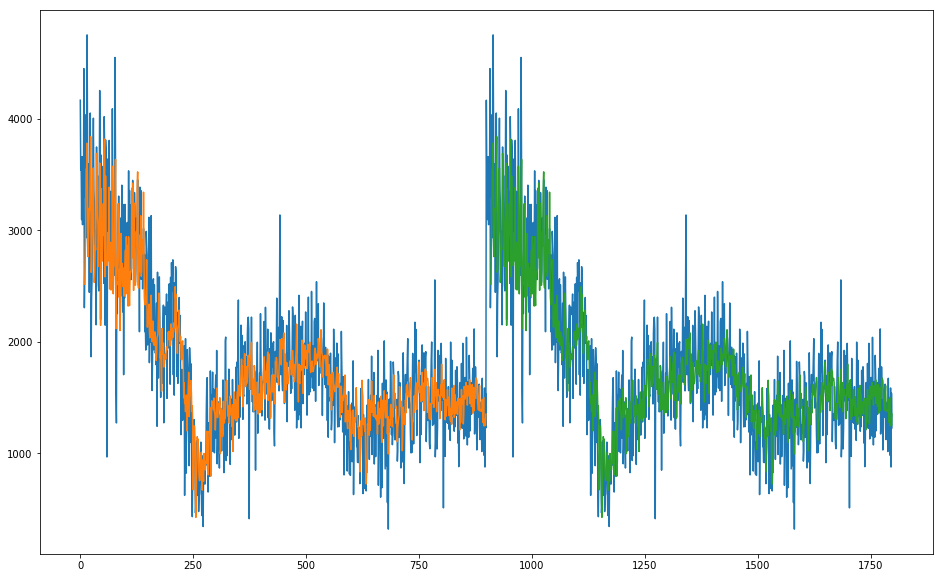

In [44]:
plt.plot(ts_all)
plt.plot(pred_train_shifted)
plt.plot(pred_test_shifted)
plt.show()

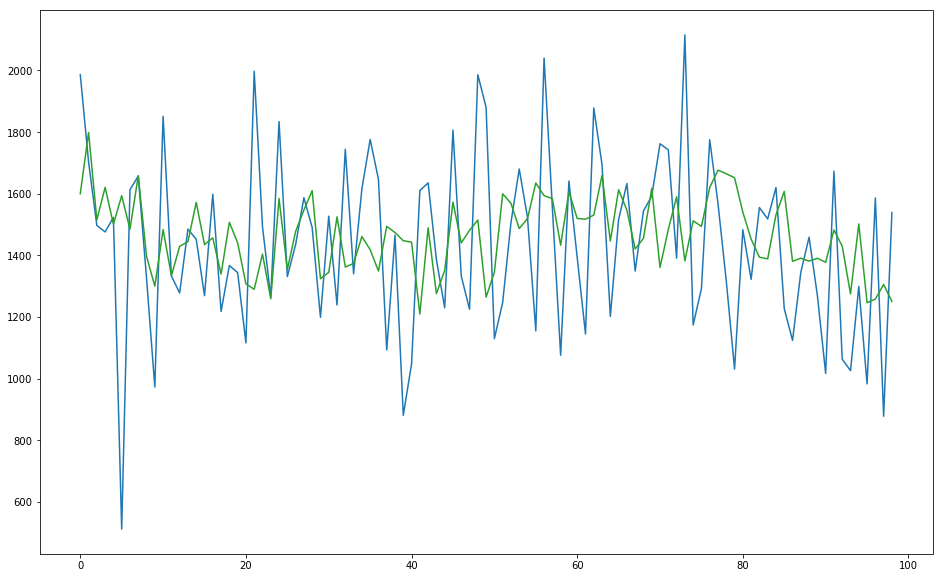

In [45]:
plot_start = -100
plot_end = -1
plt.plot(ts_all[plot_start:plot_end])
plt.plot(pred_train_shifted[plot_start:plot_end])
plt.plot(pred_test_shifted[plot_start:plot_end])
plt.savefig(fig_name)
plt.show()


In [46]:
def plot_results_multiple(predicted_data, true_data, prediction_window):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_window)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.savefig(fig_name)
    plt.show()

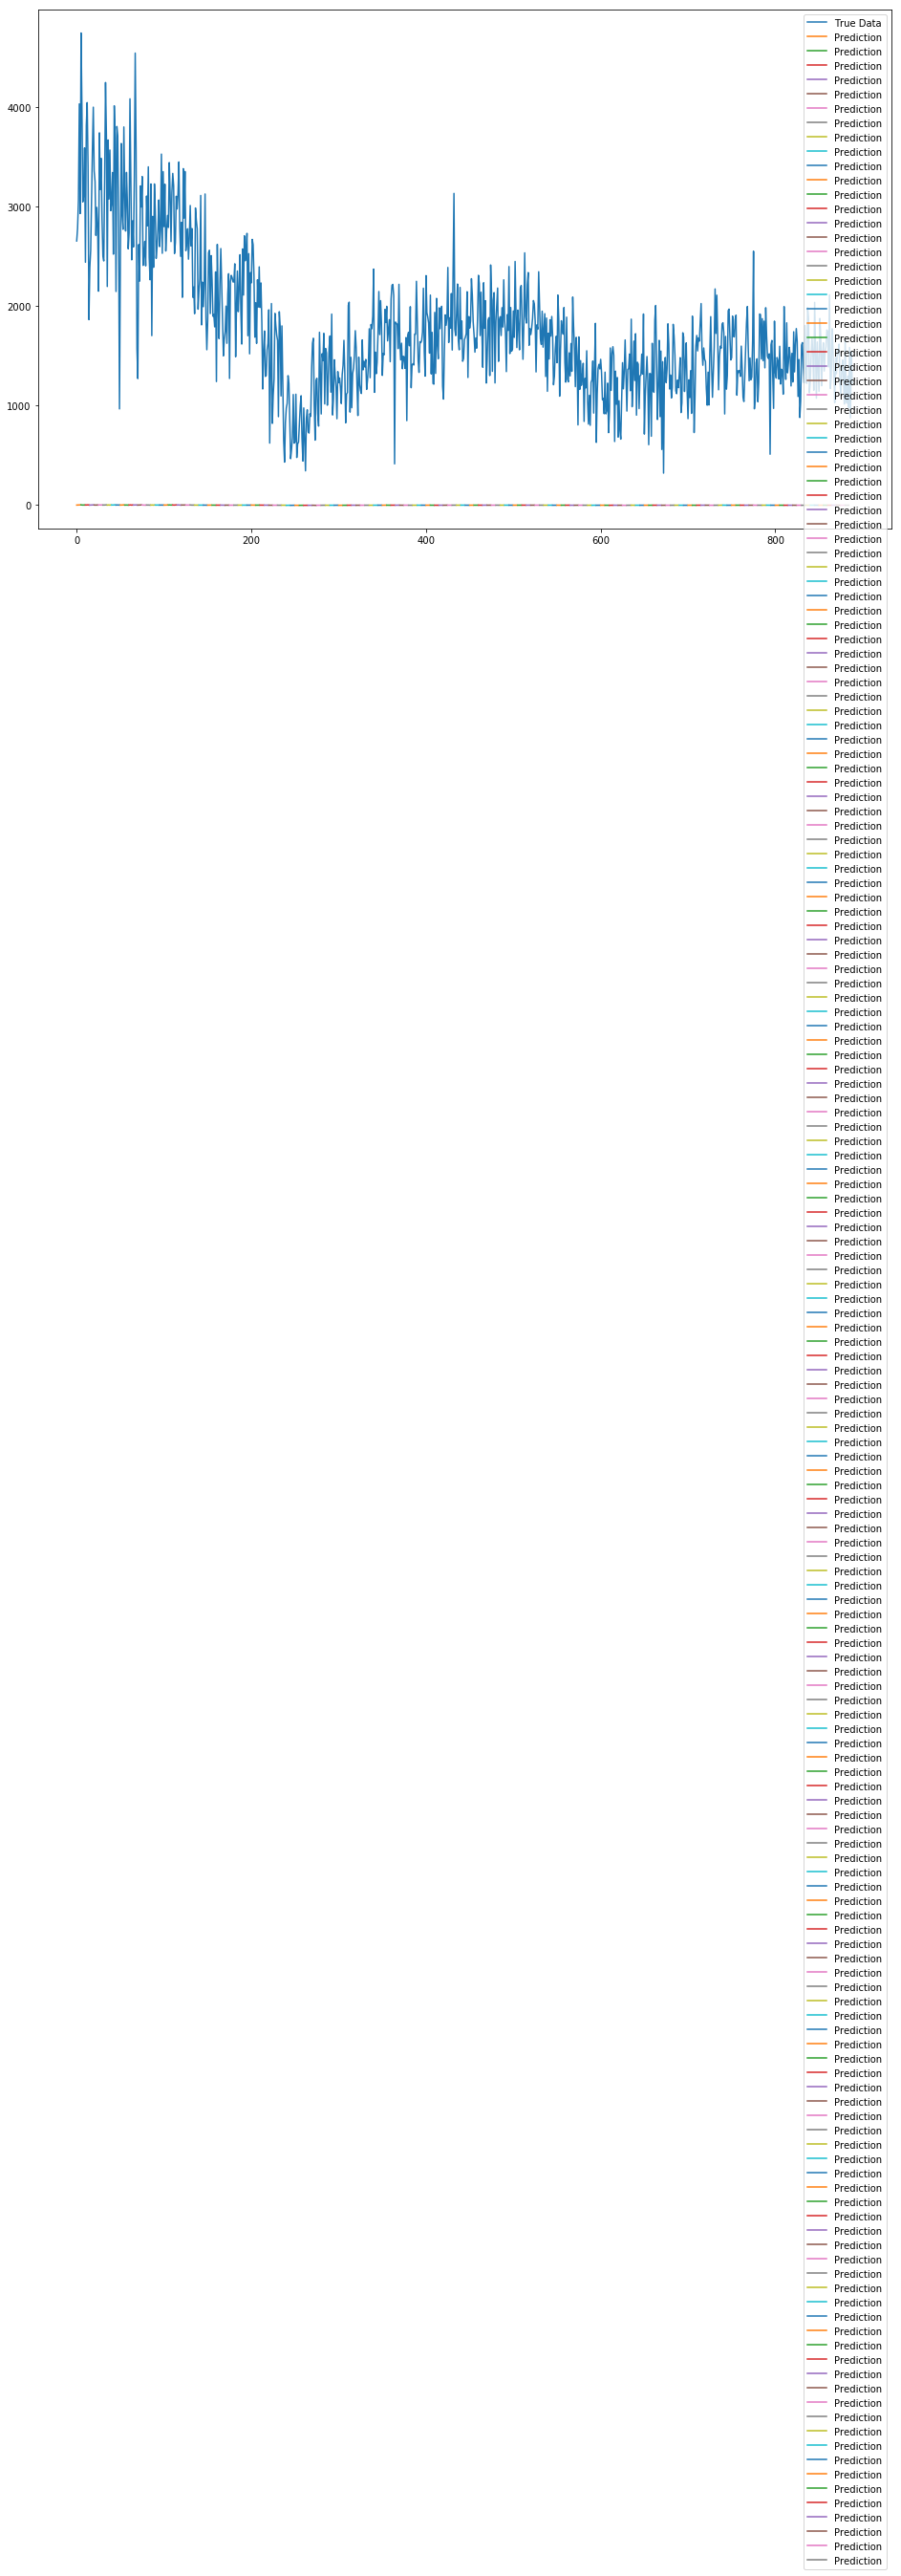

In [47]:
if use_LSTM:
    plot_results_multiple(prediction_seqs_train, y_train, prediction_window)

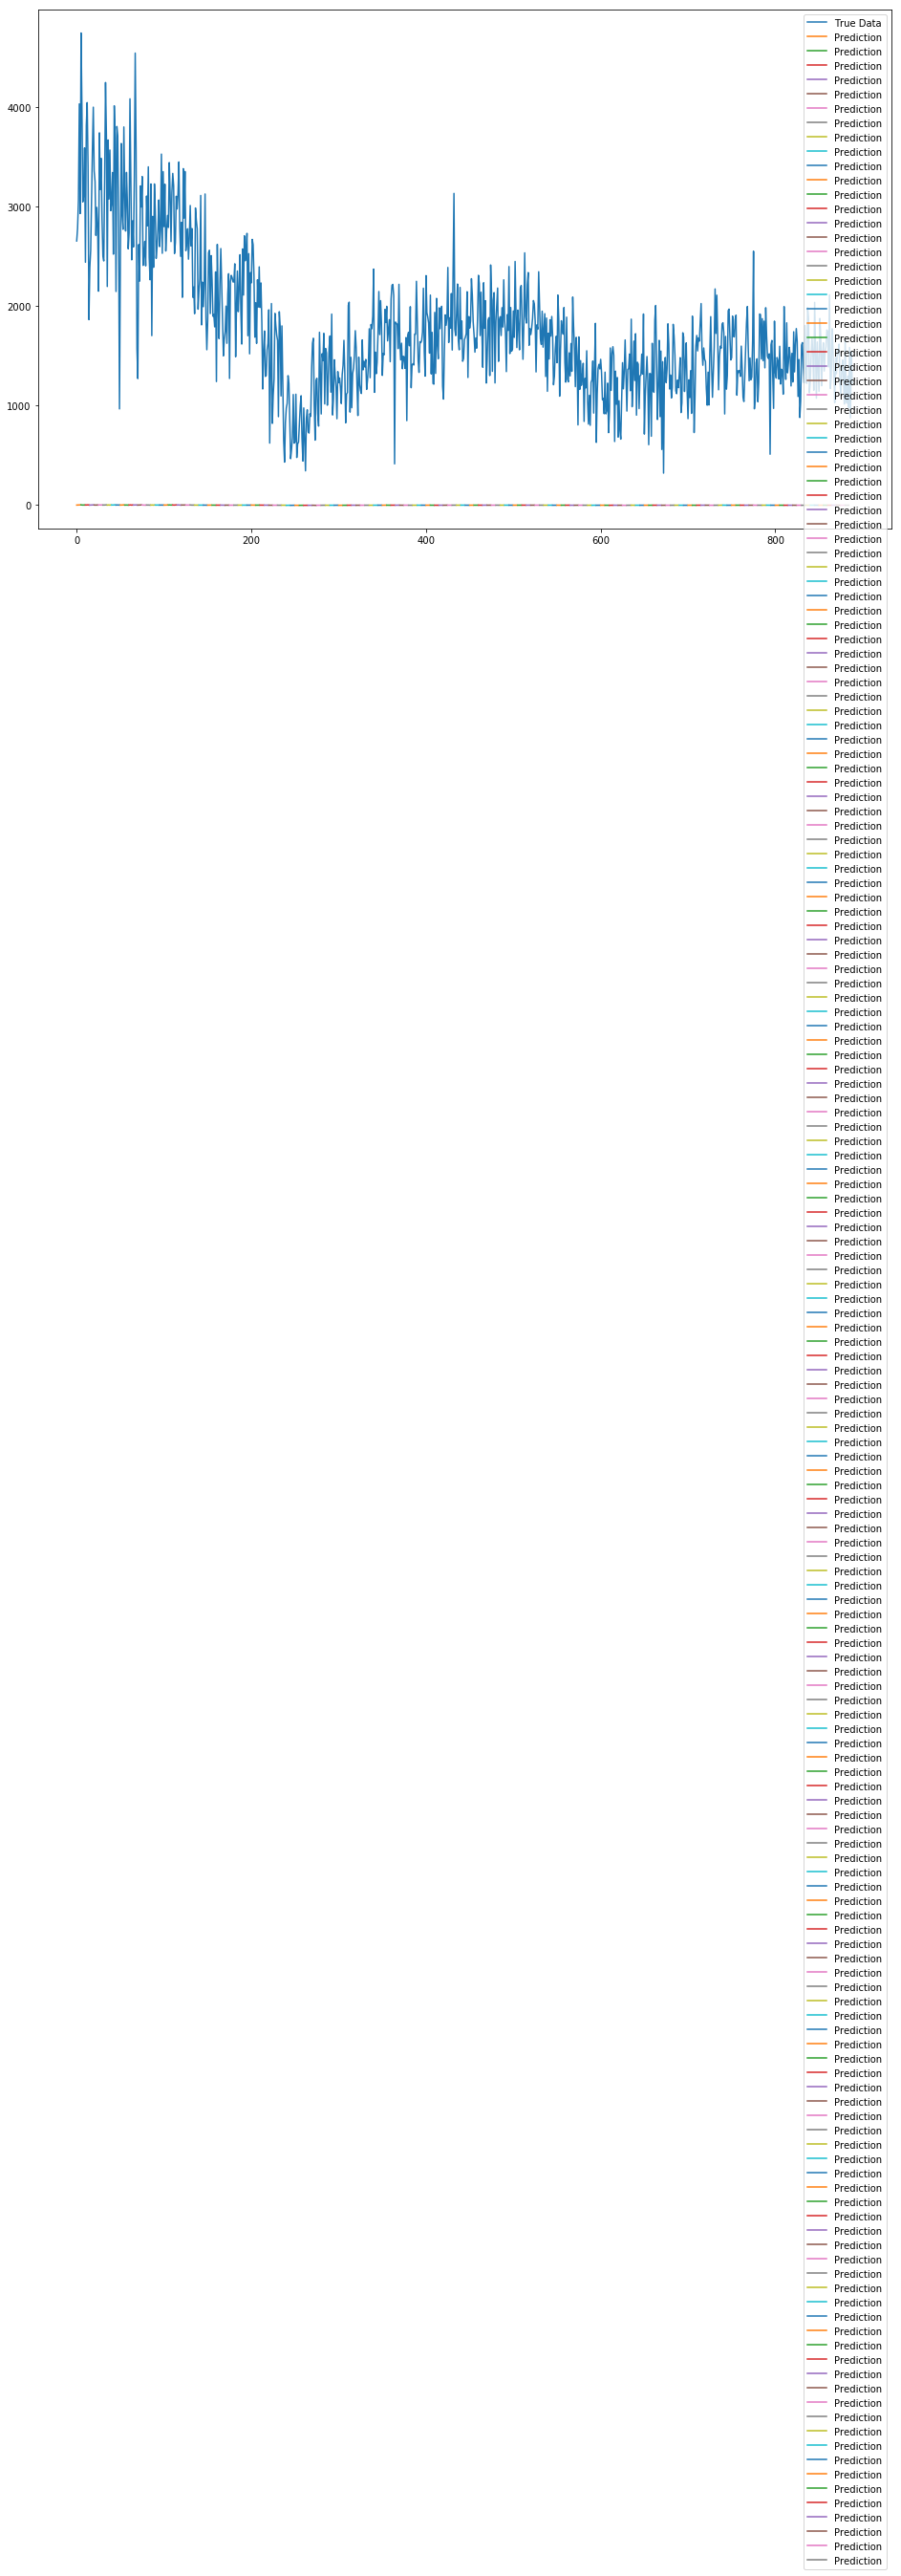

In [48]:
if use_LSTM:
    plot_results_multiple(prediction_seqs_test, y_test, prediction_window)